In [1]:
import csv
import pandas as pd
import numpy as np
#import filters  # THIS LIBRARY IS NOT INCLUDED IN THE REPOSITORY
import matplotlib.pyplot as pyp
import scipy.signal as signal
import numpy.fft as fft
import os         # ADD THIS SO WE CAN USE ENVIRONMENT VARIABLES
import matplotlib
%matplotlib inline

#print os.environ
print os.environ.get('TAU_ACC_ZHAIRES_DIR')
#print os.environ['TAU_ACC_ZHAIRES_DIR']

/Users/romerowo/Dropbox/npz_files (1)


In [2]:
pastel_colors = ['#FF6666','#FFCC66','#CCFF66','#66FF66','#66FFCC','#66FFFF','#66CCFF','#6666FF','#CC66FF','#FF66FF','#FF6FCF']
bright_colors = ['#FF0000','#FF8000','#FFFF00','#80FF00','#00FF00','#00FF80','#00FFFF','#0080FF','#0000FF','#8000FF','#FF00FF']
bright_colors2 = bright_colors = ['#FF0000','#FF8000','#80FF00','#00FF80','#0080FF','#0000FF','#8000FF','#FF00FF','#FF0080']
pyp.rcParams['font.size']=18
pyp.rcParams['legend.labelspacing'] = 0.1

In [3]:
#constants
kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K
speed_of_light = 2.988e8   # meters * Hz (ARW)
Z_0 = 377. # Ohms (ARW)
Z_L = 50. # Ohms (ARW)
R_L = 50. # Ohms (ARW)

In [4]:
def temp(f_MHz):
    # Dulk 2001
    nu = f_MHz # Hz
    tau = 5.0 * pow(nu, -2.1)
    Ieg = 1.0610e-20
    Ig  = 2.48e-20
    # Iv in  W/m^2/Hz/sr
    Iv = Ig * pow(nu, -0.52) * (1-np.exp(-tau))/tau + Ieg * pow(nu, -0.80) * np.exp(-tau)
    
    kB = 1.38064852e-23 # Watts / Hz / K
    c = 299792458 # m/s
    temp = Iv * c**2 / (2*(nu*1e6)**2)/kB

    return Iv, temp # W/m^2/Hz/sr, K

def read_npz_files(antenna_height, zenith):
    npzfile = np.load(os.environ['TAU_ACC_ZHAIRES_DIR'] + "/" + "altitude_%dkm_zenith_%d.npz"%(antenna_height, zenith))
    efield_td = npzfile['efield_td'][()] ## for some reason just reading the arrays gives a 0-dim array, so skip this.
    efield_fd = npzfile['efield_fd'][()]
    return efield_td, efield_fd

In [5]:
temp(1200)

(6.5777170277147689e-22, 1.4867603574633084)

['y_v_per_m', 'z_v_per_m', 'x_v_per_m', 'time_s']
['freq_hz', 'x_v_per_m_Hz', 'z_v_per_m_Hz', 'y_v_per_m_Hz']
dt 3.00000000007e-10
sum(V(f))*df 6.50e-11 V/m
Peak V(t)    5.61e-05 V/m

So what is wrong with ZHAireS in the Frequency Domain ?
sum(V(f))*df 9.58e-18 V/m
Don't use it. Some weird normalization issues here.


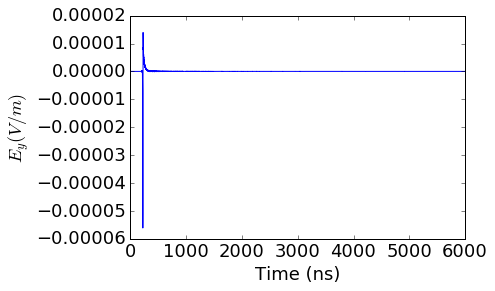

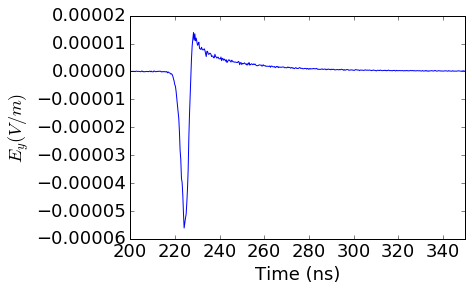

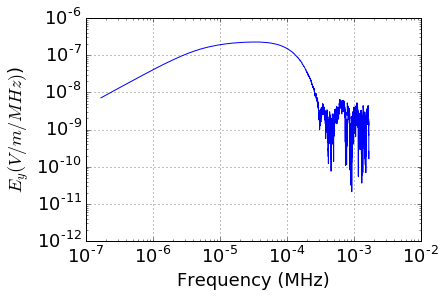

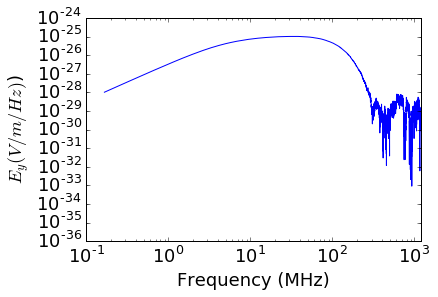

In [6]:
h = 3
z = 85
offangle = 1
efield_td, efield_fd = read_npz_files(h,z)
print efield_td[offangle].keys()
print efield_fd[offangle].keys()

def simulated_signal_td(offangle):
    '''Returns the selected simulation sampled at 
    the input off-angle (divided by 10). Simulations range between 0.1 and 4.1 degrees.
    For example, to get the waveform on the cone, use offangle=12'''
    efield = efield_td[offangle]['y_v_per_m']
    time = efield_td[offangle]['time_s']
    return np.array(time), np.array(efield)

def simulated_signal_fd(offangle):
    efield = efield_fd[offangle]['y_v_per_m_Hz']
    freq = efield_fd[offangle]['freq_hz']
    return np.array(freq), np.array(efield)

pyp.figure(1)
time, efield = simulated_signal_td(offangle)
pyp.plot((time-min(time))*1e9, efield)
#pyp.xlim(200,350)
pyp.xlabel("Time (ns)")
pyp.ylabel("$E_y (V/m)$")

pyp.figure(2)
time, efield = simulated_signal_td(offangle)
pyp.plot((time-min(time))*1e9, efield)
pyp.xlim(200,350)
pyp.xlabel("Time (ns)")
pyp.ylabel("$E_y (V/m)$")

### SANIT CHECK: I WILL FFT THE E-FIELD MYSELF AND CHECK THAT ZHAIRES MAKES SENSE ###
dt = time[1]-time[0]
print 'dt', dt
E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in µs so that fft is in units of V/m/MHz
fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz

pyp.figure(3)
pyp.loglog(fr/1.e6, np.abs(E_fft))
pyp.xlabel("Frequency (MHz)")
pyp.ylabel("$E_y (V/ m / MHz)$)")
pyp.grid(True)
# GET df TO CHECK CONSISTENCY
df = fr[1]-fr[0]
# THE SUM OF THE AMPLITUDES * df SHOULD BE CLOSE TO THE PEAK VALUE IF THE SIGNAL IS COHERENT, THE FACTOR OF len(field)/len(E_fft) is to account for the shorter length of the rfft.
print 'sum(V(f))*df %1.2e V/m'%(np.sum(np.abs(E_fft))*df/1.e6 * float(len(efield))/(len(E_fft)))
print 'Peak V(t)    %1.2e V/m'%np.max(np.abs(efield))

pyp.figure(4)
freq, efield = simulated_signal_fd(offangle)
pyp.loglog((freq)/1e6, efield)
pyp.xlim(1.e-1,1200)
pyp.xlabel("Frequency (MHz)")
# THESE UNITS ARE WRONG, FOR A FOURIER TRANSFROM THE UNITS ARE V/m/Hz pyp.ylabel("$E_y (V/(m \sqrt{Hz})$)")
pyp.ylabel("$E_y (V/ m / Hz)$)") # THESE ARE RIGHT

print '\nSo what is wrong with ZHAireS in the Frequency Domain ?'
print  'sum(V(f))*df %1.2e V/m'%((np.sum(np.abs(efield)))*(freq[1]-freq[0]))
print 'Don\'t use it. Some weird normalization issues here.'

In [7]:
# THE APPROACH BELOW SEEM OVERLY COMPLICATED, THIS IS HOW I WOULD DO IT.

def voltage(E_field, freq_Hz, Gain, Z_L, Z_A): # in the frequency domain
    # NO IMPEDANCE LOSSES YET
    val = E_field * np.sqrt(Z_L/Z_0*Gain/4./np.pi) * speed_of_light/freq_Hz
    val[0] = 0. # no DC voltage!
    # THIS IS IN UNITS OF E_field * meters, E_field is in V/m/Hz or V/m/MHz or whatever
    return val

def noise_v_sq(freq_MHz, Z_L, Z_A):
    # NO IMPEDANCE LOSSES YET
    val = kB_W_Hz_K*temp(freq_MHz)[1]*Z_L
    # This is in Volts^2/Hz
    return val 
    
def band_peak_v(voltage, freq, f_LO, bandwidth):
    df = freq[1]-freq[0]
    cut = np.logical_and(freq>=f_LO, freq<=f_LO + bandwidth)
    return np.sum(np.abs(voltage[cut]))*df

def band_rms_v(noise_v_sq, freq, f_LO, bandwidth):
    df = freq[1]-freq[0]
    cut = np.logical_and(freq>=f_LO, freq<=f_LO + bandwidth)
    return np.sqrt(np.sum(noise_v_sq[cut])*df)

def voltage_snr(voltage, noise_sq_v, freq, f_LO, bandwidth):
    sig = band_peak_v(voltage, freq, f_LO, bandwidth) 
    noise = band_rms_v(noise_sq_v, freq, f_LO, bandwidth)
    return sig / noise 

Of course no antenna is going to give you unity gain down to 100 kHz!
4.08686653055e-06 8.42038386822e-06
0.485353945202


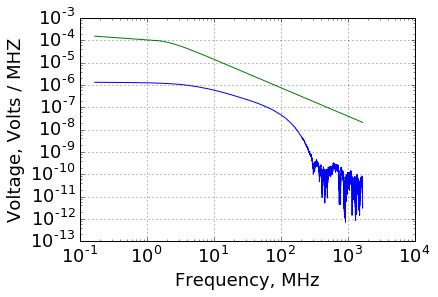

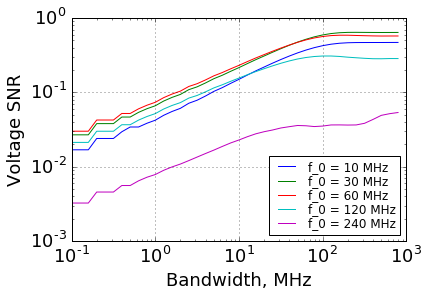

In [8]:
gain = 1. # could be an array of size fr as well
# assume unity gain, voltage proportional to sqrt(gain)
Z_L = 50.
Z_A = 50.
v_fft = voltage(E_fft, fr*1.e6, gain, 50., 50.) # frquency in Hz
noise_sq_voltage = noise_v_sq(fr, Z_L, Z_A)*1.e6 # factor of 1.e6 because it's in V^2/Hz and we want V^2/MHz

pyp.figure()
pyp.loglog(fr, np.abs(v_fft))
pyp.xlabel('Frequency, MHz')
pyp.ylabel('Voltage, Volts / MHZ')
pyp.grid(True)
print 'Of course no antenna is going to give you unity gain down to 100 kHz!'

#pyp.figure()
pyp.loglog(fr, np.sqrt(noise_sq_voltage)) 

pyp.figure()
f_Lo = 50. # MHz
bandwidth = 50. # MHz
print band_peak_v(v_fft, fr, f_Lo, bandwidth), 
print band_rms_v(noise_sq_voltage, fr, f_Lo, bandwidth)

print voltage_snr(v_fft, noise_sq_voltage, fr, f_Lo, bandwidth)

bw_list  = 10**np.arange(-1,3,0.1)
snr_list_10  = np.zeros(len(bw_list))
snr_list_30  = np.zeros(len(bw_list))
snr_list_60  = np.zeros(len(bw_list))
snr_list_120  = np.zeros(len(bw_list))
snr_list_240 = np.zeros(len(bw_list))
for k in range(0,len((bw_list))):
    snr_list_10[k] = voltage_snr(v_fft, noise_sq_voltage, fr, 10., bw_list[k])
    snr_list_30[k] = voltage_snr(v_fft, noise_sq_voltage, fr, 30., bw_list[k])
    snr_list_60[k] = voltage_snr(v_fft, noise_sq_voltage, fr, 60., bw_list[k])
    snr_list_120[k] = voltage_snr(v_fft, noise_sq_voltage, fr, 120., bw_list[k])
    snr_list_240[k] = voltage_snr(v_fft, noise_sq_voltage, fr, 240., bw_list[k])
    
pyp.figure()
pyp.loglog(bw_list, snr_list_10, label='f_0 = 10 MHz')
pyp.loglog(bw_list, snr_list_30, label='f_0 = 30 MHz')
pyp.plot(bw_list, snr_list_60, label='f_0 = 60 MHz')
pyp.plot(bw_list, snr_list_120, label='f_0 = 120 MHz')
pyp.plot(bw_list, snr_list_240, label='f_0 = 240 MHz')
pyp.xlabel('Bandwidth, MHz')
pyp.ylabel('Voltage SNR')
pyp.legend(loc=0, fontsize=12)
pyp.grid()


In [9]:
# CAN'T REALLY MONTE-CARLO THIS WITH A SPARSE ARRAY, 
# IN THE PROPER WAY, YOU SAMPLE EARTH EXIT POINT AND NEUTRINO AXES,
# THEN YOU CALCULATE THE VIEW ANGLE
# CAN'T QUITE DO THIS WITH THESE NPZ FILES

# WHAT WE CAN DO IS CHARACTERIZE USING THE FIGURE OF MERIT IN Motloch, Hollon, Privitera PAPER.
# This is A_angular = 2.*pi * integral{sin(theta) * cos(theta) * (d theta) }
# This is the solid angle figure of merit and has to get weight against area and tau exit

# this is for E=1.e17 and unity gain
def snr_vs_angle(h,z, f_Lo_list, bandwidth_list):

    off_angle_array = np.arange(0.1,4.0, 0.1)
    i_off_angle_array = range(1, len(off_angle_array)+1)
    voltage_SNR = np.zeros((len(f_Lo_list), len(bandwidth_list), len(i_off_angle_array)))
    cc = 0
    for i_offangle in i_off_angle_array:
        if(i_offangle%10==0): print i_offangle
        offangle = off_angle_array[i_offangle-1]
        efield_td, efield_fd = read_npz_files(h,z)
        efield = efield_td[i_offangle]['y_v_per_m']
        time = efield_td[i_offangle]['time_s']
        time -= time[0]
        E_fft = np.fft.rfft(efield)*dt*1.e6 # use dt in µs so that fft is in units of V/m/MHz
        fr = np.fft.rfftfreq(len(efield), dt*1.e6) # frequencies in MHz
        v_fft = voltage(E_fft, fr*1.e6, gain, 50., 50.) # frquency in Hz
        noise_sq_voltage = noise_v_sq(fr, Z_L, Z_A)*1.e6 # factor of 1.e6 because it's in V^2/Hz and we want V^2/MHz
        for i_f_Lo in range(0,len(f_Lo_list)):
            f_Lo = f_Lo_list[i_f_Lo]
            for i_bandwidth in range(0,len(bandwidth_list)):
                bandwidth = bandwidth_list[i_bandwidth]
                '''
                pyp.figure(1)
                pyp.plot(time*1.e9,efield)
                pyp.xticks(rotation=45)
                pyp.xlim(200,300)
                '''


                #pyp.figure(2)
                #pyp.loglog(fr, np.abs(v_fft))
                #print voltage_snr(v_fft, noise_sq_voltage, fr, f_Lo, bandwidth)
                snr_val = voltage_snr(v_fft, noise_sq_voltage, fr, f_Lo, bandwidth)
                #print i_f_Lo, i_bandwidth,cc, snr_val
                voltage_SNR[i_f_Lo, i_bandwidth, cc] = snr_val
        cc+=1
    #pyp.figure(3)
    #pyp.plot(off_angle_array, voltage_SNR, 'ko')
    return off_angle_array, voltage_SNR


10
20
30


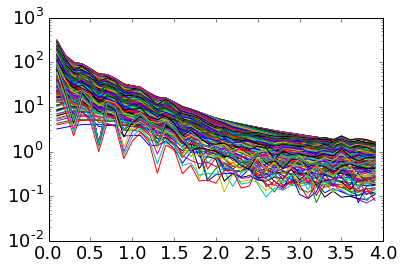

In [28]:
h=1
z=75
f_Lo_list = 10**np.arange(0.2,4.2,0.2)
bandwidth_list = 10**np.arange(1.,4.2,0.2)

psi, snr_V = snr_vs_angle(h,z, f_Lo_list, bandwidth_list)
d_psi = (psi[1]-psi[0])*np.pi/180.

snr_V *= np.sqrt(10.)
A_angular = np.zeros((len(f_Lo_list), len(bandwidth_list)))
for i_f_Lo in range(0,len(f_Lo_list)):
    f_Lo = f_Lo_list[i_f_Lo]
    for i_bandwidth in range(0,len(bandwidth_list)):
        cut = snr_V[i_f_Lo,i_bandwidth]>5.
        A_angular[i_f_Lo, i_bandwidth] = 2.*np.pi*np.sum(np.cos(psi[cut]*np.pi/180.)*np.sin(psi[cut]*np.pi/180.)*d_psi)
        pyp.semilogy(psi, snr_V[i_f_Lo, i_bandwidth,:])



16
20
(20, 16) (20, 16) (20, 16)


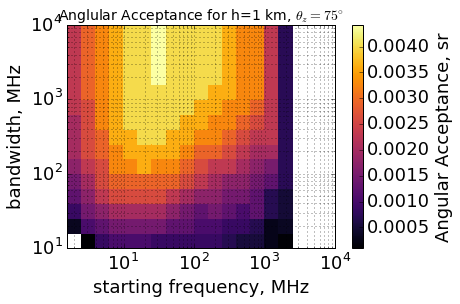

In [29]:
print len(bandwidth_list)
print len(f_Lo_list)
start_freq, bands = np.meshgrid(np.log10(bandwidth_list), np.log10(f_Lo_list))
print start_freq.shape, bands.shape, A_angular.shape

ax = pyp.subplot(111)
ax.set_xscale('log')
ax.set_yscale('log')
H=np.array(A_angular)
Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
pyp.pcolormesh(10**bands, 10**start_freq, Hmasked, cmap='inferno')
pyp.xlim(0.,1.e4)
pyp.ylim(0.,1.e4)
pyp.colorbar(label='Angular Acceptance, sr')
pyp.ylabel('bandwidth, MHz')
pyp.xlabel('starting frequency, MHz')
pyp.grid(True, which='both')
pyp.title(r'Anglular Acceptance for h=%1.0f km, $\theta_{z}=%1.0f^{\circ}$'%(h,z), fontsize=14)


In [12]:
print variable_that_does_not_exist
# this is so that the thing stops when I restart and run all

NameError: name 'variable_that_does_not_exist' is not defined

In [ ]:
# The code below is Steph's

In [ ]:
def noise_power(fstart, fstop):
    if(fstop == 0.):
        fstop = max(efield_fd[1]['freq_hz'])
    df = efield_fd[1]['freq_hz'][1] - efield_fd[1]['freq_hz'][0]
    freq = np.arange(fstart, fstop, df) # in Hertz
    
    # get the galactic noise power in the band
    noise_temp = temp(freq/1e6)[1]
    kB_W_Hz_K = 1.38064852e-23 # Watts / Hz / K

    # sum the power with a coherent power sum for the signal and incoherent for the noise
    incoherent_noise_sum = np.sum(noise_temp*kB_W_Hz_K*df)
    return incoherent_noise_sum

In [ ]:
noise_low = noise_power(30e6, 80e6)
noise_mid = noise_power(150e6, 750e6)
noise_high = noise_power(300e6, 1200e6)

In [ ]:
print noise_low, kB_W_Hz_K * 50e6 * 10000, np.sqrt(noise_low*Z_L)*1e6
print noise_mid, kB_W_Hz_K * 900e6 * 100, np.sqrt(noise_mid*Z_L)*1e6
print noise_high, kB_W_Hz_K * 900e6 * 100, np.sqrt(noise_high*Z_L)*1e6

In [ ]:

# THIS SEEMS OVERLY COMPLICATED, YOU JUST HAVE TO SELECT THE PORTION OF THE ARRAY BETWEEN TWO FREQUENCIES,
# THERE IS NO POINT IN MAKING THE RESULTS FILTER DEPENDENT
# IT WILL ALSO BE FASTER FOR AN MC.
def bandpassed_signal(offangle, fstart, fstop):
    _efield = efield_td[offangle]['y_v_per_m']
    _time = efield_td[offangle]['time_s']
    dt = _time[1]-_time[0]
    _efield_filt = filters.butter_bandpass_filter(_efield,fstart,fstop,1./dt)
    return _time, _efield_filt

def bandpassed_coherent_sum_signal(fstart,fstop):
    for offangle in range(1,41,1):
        time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
        if(offangle == 1):
            efield_filt = off_angle_efield_filt
        else:
            efield_filt += off_angle_efield_filt
    return time, efield_filt

def peak_power_td(voltage):
    return (np.max(abs(voltage)))**2/Z_L 

def coherent_power_sum_voltage_td(voltage):
    return np.sum(voltage**2)/Z_L   

def coherent_power_sum_voltage_fd(voltage):
    return np.sum(np.abs(voltage)**2)/ Z_L / len(voltage)

def voltage(offangle, fstart, fstop, gain):
    time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
    efield_fft = fft.rfft(off_angle_efield_filt)
    N = len(off_angle_efield_filt)
    freq = fft.rfftfreq(N, time[1]-time[0])
    voltage_fft = efield_fft * np.sqrt(4.*Z_L/Z_0 * pow(speed_of_light/freq,2)/(4.*np.pi) * gain)
    voltage_fft[0] = 0
    volt = fft.irfft(voltage_fft)
    return time, volt, freq, voltage_fft


def efield(offangle, fstart, fstop):
    time, off_angle_efield_filt = bandpassed_signal(offangle, fstart, fstop)
    efield_fft = fft.rfft(off_angle_efield_filt)
    return time, off_angle_efield_filt, freq, efield_fft

def bandpassed_efield_per_angle(fstart, fstop, gain=1, td=True):
    coherent_signal_sum = 0.
    peakefield_offangles = []
    
    for offangle in range(1,41,1):
        time, ef, freq, ef_fft = efield(offangle, fstart, fstop)
        peakefield_offangles.append(max(abs(ef)))
          
    peakefield_offangles = np.array(peakefield_offangles)
    
    return np.arange(0.1, 4.1,0.1), peakefield_offangles

def bandpassed_power_per_angle(fstart, fstop, gain=1, td=True):
    coherent_signal_sum = 0.
    power_offangles = []
    
    for offangle in range(1,41,1):
        time, volt, freq, voltage_fft = voltage(offangle, fstart, fstop, gain)
        N = len(volt)
        dt = time[1] - time[0]

        if( td):
            #power_offangles.append(coherent_power_sum_voltage_td(volt ))
            power_offangles.append(peak_power_td(volt))
        else:
            power_offangles.append(coherent_power_sum_voltage_fd(voltage_fft))
        
    power_off_angles = np.array(power_offangles)
    
    coherent_signal_sum = np.sum(power_off_angles)
    return np.arange(0.1, 4.1,0.1), power_off_angles, coherent_signal_sum

In [ ]:
offangles, efield_low = bandpassed_efield_per_angle(30e6, 80e6)
offangles, efield_mid = bandpassed_efield_per_angle(150e6, 750e6)
offangles, efield_high = bandpassed_efield_per_angle(300e6, 1200e6)

offangles, efield_low = bandpassed_efield_per_angle(30e6, 80e6,td=False)
offangles, efield_mid = bandpassed_efield_per_angle(150e6, 750e6,td=False)
offangles, efield_high = bandpassed_efield_per_angle(300e6, 1200e6,td=False)

In [ ]:
pyp.plot(offangles, efield_low)
print max(efield_low), max(efield_mid), max(efield_high)

In [ ]:
offangles, powers_low, total_power_low = bandpassed_power_per_angle(30e6, 80e6)
offangles, powers_mid, total_power_mid = bandpassed_power_per_angle(150e6, 750e6)
offangles, powers_high, total_power_high = bandpassed_power_per_angle(300e6, 1200e6)

offangles, powers_low, total_power_low_fd = bandpassed_power_per_angle(30e6, 80e6,td=False)
offangles, powers_mid, total_power_mid_fd = bandpassed_power_per_angle(150e6, 750e6,td=False)
offangles, powers_high, total_power_high_fd = bandpassed_power_per_angle(300e6, 1200e6,td=False)

In [ ]:
print freq[1]-freq[0], 1./(freq[1]-freq[0]), len(freq)
print time[1]-time[0], 1./(time[1]-time[0]), len(time)
print (time[1]-time[0])*(freq[1]-freq[0])

In [ ]:
print total_power_low, np.sqrt(total_power_low * Z_L)*1e6, np.sqrt(2)*np.sqrt(total_power_low_fd * Z_L)*1e6
print total_power_mid, np.sqrt(total_power_mid * Z_L)*1e6, np.sqrt(2)*np.sqrt(total_power_mid_fd * Z_L)*1e6
print total_power_high, np.sqrt(total_power_high * Z_L)*1e6, np.sqrt(2)*np.sqrt(total_power_high_fd * Z_L)*1e6

print "Power to be compared with rough estimates by Andres and Steph of\n\tEpeak ~8-20 uV over ~20 ns pulse at 30-80 MHz."

In [ ]:
pyp.plot(offangles,powers_low, 'r')
pyp.plot(offangles,powers_high, 'k')
pyp.plot(offangles,powers_mid, 'b')
pyp.xlim(0.1,4)
pyp.ylim(0)
pyp.xlabel("Off Angle (deg)")
pyp.ylabel("Signal Power (W)")

In [ ]:
pyp.plot(offangles,powers_low/noise_low, 'r')
pyp.plot(offangles,powers_high/noise_high, 'k')
pyp.plot(offangles,powers_mid/noise_mid, 'b')
pyp.xlim(0.1,4)
pyp.ylim(0)
pyp.xlabel("Off Angle (deg)")
pyp.ylabel("Power Ratio")

In [ ]:
def beam_power_ratio(fstart=0., fstop=0):
    # select a single polarization. Vertical in this case
    # filter it.
    
    # add up the received signals at all the antennas
    #time, efield_filt = bandpassed_coherent_sum_signal(fstart, fstop)
    coherent_signal_sum = bandpassed_power_per_angle(fstart, fstop)[2]

    incoherent_noise_sum = noise_power(fstart, fstop) 
    pratio = coherent_signal_sum / incoherent_noise_sum
    return pratio, coherent_signal_sum, incoherent_noise_sum

In [ ]:
pratio_low, signal_power_low, nosie_power_low = beam_power_ratio(30e6, 80e6)
pratio_high, signal_power_high, nosie_power_high = beam_power_ratio(300e6, 1200e6)
print signal_power_low, signal_power_high, signal_power_low/41., signal_power_high/41.
print pratio_low, pratio_high, pratio_low/41., pratio_high/41.

In [ ]:
#scan start frequency
start_frequencies = np.arange(30e6, 1050e6, 30e6)

pratios = []
noise_powers = []
signal_powers = []
noise_temps = []
bw = 100e6
for sf in start_frequencies:
    #print cf, bw, fstart, fstop
    fstart = sf
    fstop  = sf + bw
    #print cf/1e6, bw/1e6, fstart/1e6, fstop/1e6

    pratio, signal_power, noise = beam_power_ratio(fstart=fstart, fstop=fstop)
    pratios.append(pratio/41)
    noise_powers.append(noise)
    signal_powers.append(signal_power)

In [ ]:
pyp.plot(start_frequencies/1e6,pratios)
pyp.plot(start_frequencies/1e6, )
pyp.xlim(0,200)

In [ ]:
pyp.semilogy(start_frequencies/1e6,np.array(signal_powers)/41.)
pyp.plot(start_frequencies/1e6,noise_powers)

pyp.xlim(0,200)
print signal_powers

In [ ]:
#scan start frequency
bandwidths = np.arange(30e6, 1030e6, 50e6)

pratios = []
noise_powers = []
signal_powers = []
noise_temps = []
sf = 150e6
for bw in bandwidths:
    #print cf, bw, fstart, fstop
    fstart = sf
    fstop  = sf + bw
    #print cf/1e6, bw/1e6, fstart/1e6, fstop/1e6

    pratio, signal_power, noise = beam_power_ratio(fstart=fstart, fstop=fstop)
    pratios.append(pratio/41.)
    noise_powers.append(noise)
    signal_powers.append(signal_power/41.)

In [ ]:
pyp.plot(bandwidths/1e6,pratios)
#pyp.xlim(0,200)

In [ ]:
### two-dimensional scan of bandwidth and center frequency
start_frequencies = np.arange(30e6, 330e6, 5e6)
bandwidths = np.arange(30e6, 650e6, 50e6)

pratios2 = []
noise_powers2 = []
signal_powers2 = []
noise_temps2 = []

for bw in bandwidths:
    pratios = []
    noise_powers = []
    signal_powers = []
    noise_temps = []
    for sf in start_frequencies:
        #print cf, bw, fstart, fstop
        fstart = sf
        fstop  = sf + bw
        #print cf/1e6, bw/1e6, fstart/1e6, fstop/1e6
        
        pratio, signal_power, noise = beam_power_ratio(fstart=fstart, fstop=fstop)
        pratios.append(pratio/41.)
        noise_powers.append(noise)
        signal_powers.append(signal_power/41.)
    pratios2.append(pratios)
    noise_powers2.append(noise_powers)
    signal_powers2.append(signal_powers)

In [ ]:
#setup the 2D grid with Numpy
start_freq, bands = np.meshgrid(start_frequencies, bandwidths)

#convert intensity (list of lists) to a numpy array for plotting

pratios2 = np.array(pratios2)


#now just plug the data into pcolormesh, it's that easy!
pyp.figure(1)
mcolors = matplotlib.colors.Normalize(vmin=pratios2.min()/pratios2.max(),
                                      vmax=1.,)
pyp.pcolormesh(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 
               norm=mcolors, cmap='plasma')
pyp.colorbar() #need a colorbar to show the intensity scale

pyp.xlim(30,300)
pyp.ylim(30,600)
CS = pyp.contour(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 8, colors='k')
print CS
manual_locations = [(75,150),(100,200),(125,200), (150,200),(175,200), (200,200),(250,200) ]
pyp.clabel(CS, inline=1, fontsize=12, manual=manual_locations)

pyp.xlabel("Starting Frequency (MHz)")
pyp.ylabel("Bandwidth (MHz)")
pyp.title("Normalized Ratio of Coherent Power to Noise Power ", y=1.1)
pyp.savefig("/Users/wissels/Dropbox/MountainTop/AntennaStudy/pulse_power_over_noise_power_contour_norm_%dkm_%ddeg.png"%(h,z))

pyp.figure(2)
pyp.pcolormesh(start_freq/1e6, bands/1e6, pratios2, 
               cmap='plasma')
pyp.colorbar() #need a colorbar to show the intensity scale

pyp.xlim(30,300)
pyp.ylim(30,600)
CS = pyp.contour(start_freq/1e6, bands/1e6, pratios2/pratios2.max(), 8, colors='k')
manual_locations = [(75,150),(100,200),(125,200), (150,200),(175,200), (200,200),(250,200) ]
pyp.clabel(CS, inline=1, fontsize=12, manual=manual_locations)

pyp.xlabel("Starting Frequency (MHz)")
pyp.ylabel("Bandwidth (MHz)")
pyp.title("Ratio of Coherent Power to Noise Power ", y=1.1)
pyp.savefig("/Users/wissels/Dropbox/MountainTop/AntennaStudy/pulse_power_over_noise_power_contour_%dkm_%ddeg.png"%(h,z))